# Analysing data from multiple subjects

#### Setting up Python
Before starting to analyse our own EEG data, we need to make sure we have our virtual environment we created during the `MNE-tutorial`.

1. Press `Select Kernel`, then `Python Environments...` and then choose any Python kernel. 
2. Run the code chunk below
3. Change the kernel used to run the code in this notebook. Press where it says `Python X.XX.XX` in the top right corner, then `Select Another Kernel`, then `Jupyter kernel...` and then select `env`. If `env` does not show up, press the little refresh symbol! 

In [1]:
!bash ../env_to_ipynb_kernel.sh

Installed kernelspec env in /home/ucloud/.local/share/jupyter/kernels/env


## Importing packages

In [2]:
import mne
import numpy as np
import pandas as pd
import os

## Defining functions

In [16]:
# function for getting triggers from logfile
def get_triggers(logfile, events):

    # load information from logfile
    logfile['lexical_category'] = logfile['lexical_category'].replace(['word', 'nonword'], [0, 2])
    logfile['prime_category'] = logfile['prime_category'].replace(['congruent', 'incongruent'], [0, 1])
    logfile['target_category'] = logfile['target_category'].replace(['practice', 'compound_first', 'basic',
                                                                    'filler', 'abstract', 'subordinate', 
                                                                    'nontransparent_last', 'nontransparent_first', 
                                                                    'compound_last'], [90, 50, 20, 10, 80, 30,
                                                                                    60, 70, 40])

    # create new columns for the events
    logfile['event'] = logfile['lexical_category'] + logfile['prime_category'] + logfile['target_category']

    logfile['event_rt'] = logfile['correct'].replace([1, 0], [100, 105])
    logfile['event_rt'] = logfile['event_rt'] + logfile['event']

    # separate time for the button presses
    logfile['event_rt_time'] = logfile['time_target'] + logfile['response_time_keyboard_response']

    # create new events
    temp = []
    for ev, resp in zip(logfile['event'], logfile['event_rt']):
        temp.append(ev+5)
        temp.append(ev)
        temp.append(resp)

    time_time = []

    for p, t, r in zip(logfile['time_prime_trigger'][12:], logfile['time_target_trigger'][12:], logfile['time_resp_trigger'][12:]):
        time_time.append(p)
        time_time.append(t)
        time_time.append(r)

    temp_time = []

    for p, t, r in zip(logfile['time_prac_prime_trigger'][:12], logfile['time_prac_target_trigger'][:12], logfile['time_prac_resp_trigger'][:12]):
        temp_time.append(p)
        temp_time.append(t)
        temp_time.append(r)


    temp_dif = np.append(1, np.diff(events[:,0])) 
    tempi = np.where(temp_dif==0)[0]-1
    new_events = np.delete(events, tempi, 0)

    # insert new events into the new events array
    new_events[5:14*3-1, 2] = temp[:36]

    try:
        new_events[14*3:, 2] = temp[36:]
    except:
        new_events[14*3:-1, 2] = temp[36:]


    return new_events


# function fo preprocessing one subject
def preproc_subject(raw, logfile, event_id, bad_channels = ["Fp1", "Fp2"], reject = {"eeg":150e-6}, l_freq = 1, h_freq = 40, tmin = -0.2, tmax = 1, baseline = (-0.2, None)):
    """
    Preprocesses one subject's data.

    Parameters
    ----------
    raw : mne.io.Raw
        Raw data.
    """
    # set montage
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    
    # remove bad channels
    raw.info["bads"] = bad_channels
    raw.interpolate_bads(reset_bads = True)
    
    # bandpass filter
    raw.filter(l_freq, h_freq)
    
    # epoching
    events, _ = mne.events_from_annotations(raw, verbose=False)
    events = get_triggers(logfile, events)

    updated_event_id = get_correct_event_ids(events, event_id)

    epochs = mne.Epochs(raw, events, updated_event_id, tmin, tmax, baseline = baseline, reject = reject, preload = True)
    
    # artifact rejection
    epochs.drop_bad()
    
    return epochs

# function for getting only the event_ids found in the session
def get_correct_event_ids(events, event_id):
    # modify event id so we only have triggers from our data so we do not get an error when we are trying to run 
    triggers_unique = np.unique(events[:, 2])

    # Create a new dictionary for the selected triggers
    updated_event_ids = {}

    # Iterate through the event_id dictionary
    for key, value in event_id.items():
        if value in triggers_unique:
            updated_event_ids[key] = value

    return updated_event_ids


## Now lets get started!

In [17]:
# the big event array hurray
event_id = {'filler/congruent/word/target': 10, # filler word with congruent prime
            'filler/congruent/nonword/target': 12, # filler nonword with congruent prime
            'filler/congruent/word/correct': 110, # filler word with congruent prime - correct answer
            'filler/congruent/word/incorrect': 115, # filler word with congruent prime - incorrect answer
            'filler/congruent/nonword/correct': 112, # filler non-word with congruent prime - correct answer
            'filler/congruent/nonword/incorrect': 117, # filler non-word with congruent prime - incorrect answer
            'filler/incongruent/word/target': 11, # filler word with incongruent prime
            'filler/incongruent/nonword/target': 13, # filler nonword with incongruent prime
            'filler/incongruent/word/correct': 111, # filler word with incongruent prime - correct answer
            'filler/incongruent/word/incorrect': 116, # filler word with incongruent prime - incorrect answer
            'filler/incongruent/nonword/correct': 113, # filler non-word with incongruent prime - correct answer
            'filler/incongruent/nonword/incorrect': 118, # filler non-word with incongruent prime - incorrect answer
            'basic/congruent/word/target': 20, # basic-category word with congruent prime
            'basic/congruent/nonword/target': 22, # basic-category nonword with congruent prime
            'basic/congruent/word/correct': 120, # basic-category word with congruent prime - correct answer
            'basic/congruent/word/incorrect': 125, # basic-category word with congruent prime - incorrect answer
            'basic/congruent/nonword/correct': 122, # basic-category non-word with congruent prime - correct answer
            'basic/congruent/nonword/incorrect': 127, # basic-category non-word with congruent prime - incorrect answer
            'basic/incongruent/word/target': 21, # basic-category word with incongruent prime
            'basic/incongruent/nonword/target': 23, # basic-category nonword with incongruent prime
            'basic/incongruent/word/correct': 121, # basic-category word with incongruent prime - correct answer
            'basic/incongruent/word/incorrect': 126, # basic-category word with incongruent prime - incorrect answer
            'basic/incongruent/nonword/correct': 123, # basic-category non-word with incongruent prime - correct answer
            'basic/incongruent/nonword/incorrect': 128, # basic-category non-word with incongruent prime - incorrect answer
            'subordinate/congruent/word/target': 30, # subordinate word with congruent prime
            'subordinate/congruent/nonword/target': 32, # subordinate nonword with congruent prime
            'subordinate/congruent/word/correct': 130, # subordinate word with congruent prime - correct answer
            'subordinate/congruent/word/incorrect': 135, # subordinate word with congruent prime - incorrect answer
            'subordinate/congruent/nonword/correct': 132, # subordinate non-word with congruent prime - correct answer
            'subordinate/congruent/nonword/incorrect': 137, # subordinate non-word with congruent prime - incorrect answer
            'subordinate/incongruent/word/target': 31, # subordinate word with incongruent prime
            'subordinate/incongruent/nonword/target': 33, # subordinate nonword with incongruent prime
            'subordinate/incongruent/word/correct': 131, # subordinate word with incongruent prime - correct answer
            'subordinate/incongruent/word/incorrect': 136, # subordinate word with incongruent prime - incorrect answer
            'subordinate/incongruent/nonword/correct': 133, # subordinate non-word with incongruent prime - correct answer
            'subordinate/incongruent/nonword/incorrect': 138, # subordinate non-word with incongruent prime - incorrect answer
            'compoundlast/congruent/word/target': 40, # compound-last word with congruent prime
            'compoundlast/congruent/nonword/target': 42, # compound-last nonword with congruent prime
            'compoundlast/congruent/word/correct': 140, # compound-last word with congruent prime - correct answer
            'compoundlast/congruent/word/incorrect': 145, # compound-last word with congruent prime - incorrect answer
            'compoundlast/congruent/nonword/correct': 142, # compound-last non-word with congruent prime - correct answer
            'compoundlast/congruent/nonword/incorrect': 147, # compound-last non-word with congruent prime - incorrect answer
            'compoundlast/incongruent/word/target': 41, # compound-last word with incongruent prime
            'compoundlast/incongruent/nonword/target': 43, # compound-last nonword with incongruent prime
            'compoundlast/incongruent/word/correct': 141, # compound-last word with incongruent prime - correct answer
            'compoundlast/incongruent/word/incorrect': 146, # compound-last word with incongruent prime - incorrect answer
            'compoundlast/incongruent/nonword/correct': 143, # compound-last non-word with incongruent prime - correct answer
            'compoundlast/incongruent/nonword/incorrect': 148, # compound-last non-word with incongruent prime - incorrect answer
            'compoundfirst/congruent/word/target': 50, # compound-first word with congruent prime
            'compoundfirst/congruent/nonword/target': 52, # compound-first nonword with congruent prime
            'compoundfirst/congruent/word/correct': 150, # compound-first word with congruent prime - correct answer
            'compoundfirst/congruent/word/incorrect': 155, # compound-first word with congruent prime - incorrect answer
            'compoundfirst/congruent/nonword/correct': 152, # compound-first non-word with congruent prime - correct answer
            'compoundfirst/congruent/nonword/incorrect': 157, # compound-first non-word with congruent prime - incorrect answer
            'compoundfirst/incongruent/word/target': 51, # compound-first word with incongruent prime
            'compoundfirst/incongruent/nonword/target': 53, # compound-first nonword with incongruent prime
            'compoundfirst/incongruent/word/correct': 151, # compound-first word with incongruent prime - correct answer
            'compoundfirst/incongruent/word/incorrect': 156, # compound-first word with incongruent prime - incorrect answer
            'compoundfirst/incongruent/nonword/correct': 153, # compound-first non-word with incongruent prime - correct answer
            'compoundfirst/incongruent/nonword/incorrect': 158, # compound-first non-word with incongruent prime - incorrect answer
            'nontransparentlast/congruent/word/target': 60, # nontransparent compound-last word with congruent prime
            'nontransparentlast/congruent/nonword/target': 62, # nontransparent compound-last nonword with congruent prime
            'nontransparentlast/congruent/word/correct': 160, # nontransparent compound-last word with congruent prime - correct answer
            'nontransparentlast/congruent/word/incorrect': 165, # nontransparent compound-last word with congruent prime - incorrect answer
            'nontransparentlast/congruent/nonword/correct': 162, # nontransparent compound-last non-word with congruent prime - correct answer
            'nontransparentlast/congruent/nonword/incorrect': 167, # nontransparent compound-last non-word with congruent prime - incorrect answer
            'nontransparentlast/incongruent/word/target': 61, # nontransparent compound-last word with incongruent prime
            'nontransparentlast/incongruent/nonword/target': 63, # nontransparent compound-last nonword with incongruent prime
            'nontransparentlast/incongruent/word/correct': 161, # nontransparent compound-last word with incongruent prime - correct answer
            'nontransparentlast/incongruent/word/incorrect': 166, # nontransparent compound-last word with incongruent prime - incorrect answer
            'nontransparentlast/incongruent/nonword/correct': 163, # nontransparent compound-last non-word with incongruent prime - correct answer
            'nontransparentlast/incongruent/nonword/incorrect': 168, # nontransparent compound-last non-word with incongruent prime - incorrect answer
            'nontransparentfirst/congruent/word/target': 70, # nontransparent compound-first word with congruent prime
            'nontransparentfirst/congruent/nonword/target': 72, # nontransparent compound-first nonword with congruent prime
            'nontransparentfirst/congruent/word/correct': 170, # nontransparent compound-first word with congruent prime - correct answer
            'nontransparentfirst/congruent/word/incorrect': 175, # nontransparent compound-first word with congruent prime - incorrect answer
            'nontransparentfirst/congruent/nonword/correct': 172, # nontransparent compound-first non-word with congruent prime - correct answer
            'nontransparentfirst/congruent/nonword/incorrect': 177, # nontransparent compound-first non-word with congruent prime - incorrect answer
            'nontransparentfirst/incongruent/word/target': 71, # nontransparent compound-first word with incongruent prime
            'nontransparentfirst/incongruent/nonword/target': 73, # nontransparent compound-first nonword with incongruent prime
            'nontransparentfirst/incongruent/word/correct': 171, # nontransparent compound-first word with incongruent prime - correct answer
            'nontransparentfirst/incongruent/word/incorrect': 176, # nontransparent compound-first word with incongruent prime - incorrect answer
            'nontransparentfirst/incongruent/nonword/correct': 173, # nontransparent compound-first non-word with incongruent prime - correct answer
            'nontransparentfirst/incongruent/nonword/incorrect': 178, # nontransparent compound-first non-word with incongruent prime - incorrect answer
            'abstract/congruent/word/target': 80, # abstract word with congruent prime
            'abstract/congruent/nonword/target': 82, # abstract word with congruent prime
            'abstract/congruent/word/correct': 180, # abstract word with congruent prime - correct answer
            'abstract/congruent/word/incorrect': 185, # abstract word with congruent prime - incorrect answer
            'abstract/congruent/nonword/correct': 182, # abstract non-word with congruent prime - correct answer
            'abstract/congruent/nonword/incorrect': 187, # abstract non-word with congruent prime - incorrect answer
            'abstract/incongruent/word/target': 81, # abstract word with incongruent prime
            'abstract/incongruent/nonword/target': 83, # abstract fumbelword with incongruent prime
            'abstract/incongruent/word/correct': 181, # abstract word with incongruent prime - correct answer
            'abstract/incongruent/word/incorrect': 186, # abstract word with incongruent prime - incorrect answer
            'abstract/incongruent/nonword/correct': 183, # abstract non-word with incongruent prime - correct answer
            'abstract/incongruent/nonword/incorrect': 188, # abstract non-word with incongruent prime - incorrect answer
            'practice/congruent/word/target': 90, # practice word with congruent prime
            'practice/congruent/nonword/target': 92, # practice word with congruent prime
            'practice/congruent/word/correct': 190, # practice word with congruent prime - correct answer
            'practice/congruent/word/incorrect': 195, # practice word with congruent prime - incorrect answer
            'practice/congruent/nonword/correct': 192, # practice non-word with congruent prime - correct answer
            'practice/congruent/nonword/incorrect': 197, # practice non-word with congruent prime - incorrect answer
            'practice/incongruent/word/target': 91, # practice word with incongruent prime
            'practice/incongruent/nonword/target': 93,                                  # practice word with congruent prime
            'practice/incongruent/word/correct': 191, # practice word with incongruent prime - correct answer
            'practice/incongruent/word/incorrect': 196, # practice word with incongruent prime - incorrect answer
            'practice/incongruent/nonword/correct': 193, # practice non-word with incongruent prime - correct answer
            'practice/incongruent/nonword/incorrect': 198 # practice non-word with incongruent prime - incorrect answer
           }

In [28]:
# dictionary with subjects and their bad channels
subjects = {
    "group1": {"bad_channels": ["Fp1", "Fp2"], "epochs": None},
    "group3": {"bad_channels": ["Fp1", "Fp2"], "epochs": None},
    #"group4": {"bad_channels": ["Fp1", "Fp2"], "epochs": None},
    "group5": {"bad_channels": ["Fp1", "Fp2"], "epochs": None},
    "group 6": {"bad_channels": ["Fp1", "Fp2"], "epochs": None},
    #"group7": {"bad_channels": ["Fp1", "Fp2"], "epochs": None},
}

# path to the data folder
data_folder = '/work/811462/'


# loop over the subjects and preprocess their data
for subject, params in subjects.items():
    # load EEG data
    data_path = os.path.join(data_folder, f"{subject}.vhdr")
    raw = mne.io.read_raw_brainvision(data_path)
    raw.load_data()

    # load logfile
    logfile_path = os.path.join(data_folder, f"subject-{subject[-1]}.csv")
    logfile = pd.read_csv(logfile_path)

    # preprocess the data
    epochs = preproc_subject(raw, logfile, event_id, bad_channels = params["bad_channels"])
    params["epochs"] = epochs

Extracting parameters from /work/811462/group1.vhdr...
Setting channel info structure...
Reading 0 ... 675439  =      0.000 ...   675.439 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 96.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
442 matching events found
Setting baseline interval to [-0.2, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 442 events and 1201 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'FC6', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FC5', 'T7', 'FC6', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'O1', 'O2', 'P8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'O1', 'Oz', 'O2', 'P8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['Fp1', 'F4', 'Fp2']
12 bad epochs dropped
Extracting parameters from /work/811462/group3.vhdr...
S

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FT10', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['TP9']
21 bad epochs dropped
Extracting parameters from /work/811462/group5.vhdr...
Setting channel info structure...
Reading 0 ... 298099  =      0.000 ...   298.099 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 96.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'TP9', 'CP5', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9', 'P7']
    Rejecting  epoch based on EEG : ['TP9', 'Oz', 'P8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'Oz', 'P8', 'TP10']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'TP9']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FC5', 'T7', 'TP9', 'CP5', 'P7', 'O1', 'P8', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'T7', 'TP9', 'P7', 'P8', 'TP10', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'P8', 'TP10', 'T8', 'FT10', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'P7', 'O1',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
268 matching events found
Setting baseline interval to [-0.2, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 268 events and 1201 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'CP1', 'O1', 'Oz', 'P8', 'CP2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['P4', 'P8']
    Rejecting  epoch based on EEG : ['P4', 'P8']
    Rejecting  epoch based on EEG : ['CP5', 'P8']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1', 'Oz', 'O2', 'P4']
    Rejecting  epoch based on EEG : ['Pz', 'Oz']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1', 'P8']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1', 'P8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch

In [29]:
# concatenate all epochs
epochs_all_subjects = mne.concatenate_epochs([params["epochs"] for params in subjects.values()])

Not setting metadata
857 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_6474/1584747505.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_all_subjects = mne.concatenate_epochs([params["epochs"] for params in subjects.values()])


## Plotting
Now that the epochs for each participant has been extracted and concatenated together, it is time to do some plotting! Much like we have done the two other days, try and compare and contrast evokeds of two or more conditions. Here is a small example!

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "gfp"
combining channels using "gfp"


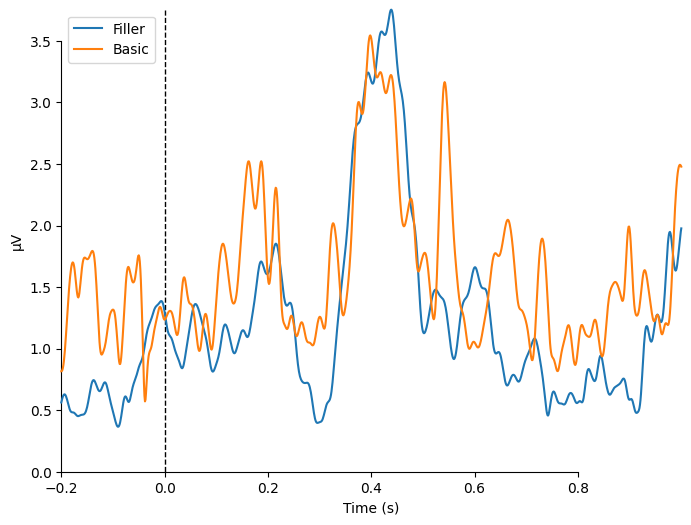

[<Figure size 800x600 with 1 Axes>]

In [30]:
filler_evokeds = epochs_all_subjects["filler"].average()
basic_evokeds = epochs_all_subjects["basic"].average()

mne.viz.plot_compare_evokeds({"Filler": filler_evokeds, "Basic": basic_evokeds})